## Personalized Learning (Localized Learning?)

#### This notebook includes the following online models;
1. A single global model with all data
2. Multiple local models (starting from a single global model)
   1. that are updated with new data
   2. that exchanges data in clusters
   3. that exchanges parameters in clusters

  
#### The dataset that is used for this project is [CIFAR-100 dataset][1]
* Has 100 classes containing 600 images each

#### New data are fed by the following rules;
1. Distributed, according to superclasses
  * Clusters will only be updated with data that belongs to a specific superclass
  * We update the NN by
    1. Changing all parameters of the NN
    2. Only changing the last few layers, as in many MTL models
2. Randomly (why?)

#### We expect to find an answer to the following research questions with this project;
1. If models are updated with data (or parameters) that are shared within a cluster, can the model perform good enough with the labels that count?
  * For example, the performance of the cluster that are updated with "Vehicles" superclass is only assessed with the labels that corresponds to the superclass.
  
[1]: https://www.cs.toronto.edu/~kriz/cifar.html

#### Questions

Retraining: how does it work <br>
How do we compare these models?


### Implementation with Custom Neural Network and EMNIST dataset

In [1]:
%load_ext tensorboard

In [180]:
from __future__ import print_function
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K

In [181]:
import matplotlib
import copy

In [182]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

In [183]:
import semantic_drift

In [184]:
import tensorflow as tf
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [215]:
import importlib
importlib.reload(semantic_drift)

<module 'semantic_drift' from '/home/seth/projects/fed-learn-experiment/semantic_drift.py'>

In [186]:
tf.__version__

'1.15.2'

In [187]:
# Hyperparameters
batch_size = 50
epochs = 20

# input image dimensions
img_rows, img_cols = 28, 28

#### Load MNIST dataset

In [188]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test_orig) = mnist.load_data()

In [189]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [190]:
x_train.shape

(60000, 28, 28, 1)

In [191]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [192]:
global_dataset_size = 6000
local_dataset_size = 40000

In [193]:
import utils

In [194]:
import importlib
importlib.reload(utils)

<module 'utils' from '/home/seth/projects/fed-learn-experiment/utils.py'>

In [195]:
TRAIN_DATA_SIZE = 1000

In [196]:
# convert class vectors to binary class matrices
num_classes = 10


In [197]:
y_test = keras.utils.to_categorical(y_test_orig, num_classes)

In [198]:
y_train_onehot = keras.utils.to_categorical(y_train, num_classes)

### Define models and compile & fit function

In [199]:
def custom_model():
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [200]:
def compile_model(model):  
    # initiate SGD optimizer
    opt = keras.optimizers.SGD(lr=0.1)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])

In [201]:
def compile_model_lr(model):  
    # initiate SGD optimizer
    opt = keras.optimizers.SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])

In [202]:
def fit_model_global(model, epochs):
    now = datetime.datetime.now()
    print ("Training date and time : ")
    print (now.strftime("%Y-%m-%d %H:%M:%S"))
    return model.fit(X_global, Y_global,
                      batch_size=100,
                      epochs=40,
                      shuffle=True, callbacks=[tensorboard_callback])

In [203]:
def fit_model_with_datasets(model, epochs, x_train, y_train):
    now = datetime.datetime.now()
    print ("Training date and time : ")
    print (now.strftime("%Y-%m-%d %H:%M:%S"))
    return model.fit(x_train, y_train,
                      batch_size=50,
                      epochs=epochs,
                      shuffle=True, verbose=1)

In [204]:
def add_hist_to_dict(d, hist):
    if 'loss' not in d:
        d['loss'] = hist[0]
    else:
        d['loss'] = np.append(d['loss'], hist[0])
    if 'acc' not in d:
        d['acc'] = hist[1]
    else:
        d['acc'] = np.append(d['acc'], hist[1])

In [159]:
importlib.reload(semantic_drift)

<module 'semantic_drift' from '/home/seth/projects/fed-learn-experiment/semantic_drift.py'>

In [168]:
a = np.array([1,2,22,4,8,11,100,30])
b = np.array([1,2,22,4,9,20,12,31,40])

In [169]:
semantic_drift.get_intersect_params_coeff(a,b)

[ 1  2 22  4]
[ 1  2 22  4]
1.0


0.5

## Fisher info test

In [64]:
model1 = custom_model()
model2 = custom_model()
compile_model(model1)
compile_model(model2)

In [66]:
model0 = custom_model()
model0.set_weights(model1.get_weights())
compile_model(model0)

In [67]:
fit_model_with_datasets(model0, 20, x_train[:1000], y_train_onehot[:1000])
fit_model_with_datasets(model1, 20, x_train[:1000], y_train_onehot[:1000])
fit_model_with_datasets(model2, 20, x_train[:1000], y_train_onehot[:1000])

Training date and time : 
2020-09-20 12:34:45
Train on 1000 samples
Epoch 1/20
1000/1000 [==============================] - 1s 856us/sample - loss: 0.0900 - acc: 0.1600
Epoch 2/20
1000/1000 [==============================] - 0s 66us/sample - loss: 0.0895 - acc: 0.1830
Epoch 3/20
1000/1000 [==============================] - 0s 64us/sample - loss: 0.0889 - acc: 0.2120
Epoch 4/20
1000/1000 [==============================] - 0s 65us/sample - loss: 0.0883 - acc: 0.2350
Epoch 5/20
1000/1000 [==============================] - 0s 63us/sample - loss: 0.0877 - acc: 0.2700
Epoch 6/20
1000/1000 [==============================] - 0s 59us/sample - loss: 0.0871 - acc: 0.3060
Epoch 7/20
1000/1000 [==============================] - 0s 62us/sample - loss: 0.0864 - acc: 0.3370
Epoch 8/20
1000/1000 [==============================] - 0s 59us/sample - loss: 0.0857 - acc: 0.3730
Epoch 9/20
1000/1000 [==============================] - 0s 57us/sample - loss: 0.0849 - acc: 0.4120
Epoch 10/20
1000/1000 [========

In [62]:
d = {}
for i in range(10):
    d[i] = 4
txf, tyf = utils.filter_data_by_labels_with_numbers(x_test, y_test_orig, np.arange(10), d)

In [68]:
semantic_drift.get_fisher_distance(model0, model1, txf)

0.024947194

In [77]:
semantic_drift.get_fisher_distance(model1, model2, txf)

1.2450087

In [70]:
#aggregate
weights = [model1.get_weights(), model2.get_weights()]
agg_weights = list()
theta = 0.5
for weights_list_tuple in zip(*weights):
    agg_weights.append(np.array([np.average(np.array(w), axis=0, weights=[1. - theta, theta]) for w in zip(*weights_list_tuple)]))
aggr_model12 = keras.models.clone_model(model1)
aggr_model12.set_weights(agg_weights)
compile_model(aggr_model12)

In [71]:
#aggregate
weights = [model0.get_weights(), model1.get_weights()]
agg_weights = list()
theta = 0.5
for weights_list_tuple in zip(*weights):
    agg_weights.append(np.array([np.average(np.array(w), axis=0, weights=[1. - theta, theta]) for w in zip(*weights_list_tuple)]))
aggr_model01 = keras.models.clone_model(model1)
aggr_model01.set_weights(agg_weights)
compile_model(aggr_model01)

In [72]:
aggr_model12.evaluate(x_test, y_test)

10000/10000 [==============================] - 1s 142us/sample - loss: 0.0875 - acc: 0.3416


[0.0874780078291893, 0.3416]

In [73]:
aggr_model01.evaluate(x_test, y_test)

10000/10000 [==============================] - 1s 147us/sample - loss: 0.0736 - acc: 0.5537


[0.0736111164689064, 0.5537]

## Dist metric test

In [98]:
import sys
sys.path.insert(0, './swarm_exp/top-k-kendall-tau/')
sys.path.insert(0, './swarm_exp/rbo/')

In [8]:
import kendall

In [113]:
importlib.reload(kendall)

<module 'kendall' from './swarm_exp/top-k-kendall-tau/kendall.py'>

In [128]:
a = np.array([2,1,5,4,3])
b = np.array([1,2,3,4,5])

In [129]:
kendall.kendall_top_k(a,b)

0.0

In [46]:
k=4
a_top_k = np.argpartition(a,-k)
b_top_k = np.argpartition(b,-k)

In [47]:
a_top_k

array([3, 2, 1, 0, 4, 5])

In [48]:
b_top_k

array([0, 1, 2, 3, 4, 5])

In [11]:
import scipy.stats as stats

In [134]:
at = np.array([5,4,3,2,1])
bt = np.array([5,4,3,2,1])

In [135]:
stats.kendalltau(at,bt)

KendalltauResult(correlation=0.9999999999999999, pvalue=0.016666666666666666)

In [99]:
from rbo import rbo

In [103]:
rbo(at, bt, p=.9)

RBO(min=0.23968557622089903, res=0.4582234094933868, ext=0.37089000000000005)

### Check in what epoch the model starts to overfit for labels 0 ~ 4.
I think it's 20 again

In [30]:
def get_losses_for_overlapping_labels_req_rounds(model, epochs, x_train, y_train, x_test, y_test, size, diff):
    """
    only overlap label 4
    """
    num_total_classes = 10 # todo np.unique(y_train)
    
    res = {}
    res['model_aggr'] = {}
    res['model_0to4'] = {}
    res['model_5to9'] = {}
    res['model_aggr']['test_all'] = {}
    res['model_aggr']['test_0to4'] = {}
    res['model_aggr']['test_5to9'] = {}
    res['model_aggr']['test_0'] = {}
    
    
    res['model_0to4'] = copy.deepcopy(res['model_aggr'])
    res['model_5to9'] = copy.deepcopy(res['model_aggr'])
    
    additionals = {}
    additionals['l2_dist'] = []
    additionals['req_rounds'] = []
    
    y_test_one_hot = keras.utils.to_categorical(y_test, num_total_classes)
    tx1, ty1 = utils.filter_data_by_labels(x_test, y_test, np.arange(5), 1000)
    tx2, ty2 = utils.filter_data_by_labels(x_test, y_test, np.arange(5)+5, 1000)
    tx0, ty0 = utils.filter_data_by_labels(x_test, y_test, np.arange(1), 200)
    
    ty1 = keras.utils.to_categorical(ty1, num_total_classes)
    ty2 = keras.utils.to_categorical(ty2, num_total_classes)
    ty0 = keras.utils.to_categorical(ty0, num_total_classes)
    
    label_move = 2
    
    for r in np.arange(0, label_move, diff):
        print("--------------  Iteration #{}  --------------".format((int)(r/diff)))
        
        # get data
        randseed = (int)(np.random.rand(1)[0] * 1000) + 2
        x1, y1 = utils.filter_data_by_labels(x_train, y_train, np.arange(5), size, 0, randseed)
        
        label_conf = {}
        start_label = (int)(r)
        end_label = 4 + start_label
        for i in np.arange(0, start_label, 1):
            label_conf[i] = 0
        for i in np.arange(start_label, end_label+2, 1):
            if i == start_label:
                label_conf[i] = (int)(120 * (1-(r-start_label)))
            elif i == end_label+1:
                label_conf[i] = 120 - (label_conf[start_label])
            else:
                label_conf[i] = 120

        x2, y2 = utils.filter_data_by_labels_with_numbers(x_train, 
                                                          y_train, 
                                                          np.arange(end_label+2), 
                                                          label_conf,
                                                          randseed+1000)

        y1 = keras.utils.to_categorical(y1, num_total_classes)
        y2 = keras.utils.to_categorical(y2, num_total_classes)
        
        # initialize models
        model1 = keras.models.clone_model(model)
        model2 = keras.models.clone_model(model)
        model1.set_weights(model.get_weights())
        model2.set_weights(model.get_weights())
        compile_model(model1)
        compile_model(model2)
        
        # fit
        fit_model_with_datasets(model1, 20, x1, y1)
        fit_model_with_datasets(model2, 20, x2, y2)
        
        additionals['l2_dist'].append(semantic_drift.get_fisher_distance(model1, model2, tx1))
        
        # test
        add_hist_to_dict(res['model_0to4']['test_all'],
                         model1.evaluate(x=x_test, y=y_test_one_hot, verbose=0))
        add_hist_to_dict(res['model_0to4']['test_0to4'],
                         model1.evaluate(x=tx1, y=ty1, verbose=0))
        add_hist_to_dict(res['model_0to4']['test_5to9'],
                         model1.evaluate(x=tx2, y=ty2, verbose=0))
        add_hist_to_dict(res['model_0to4']['test_0'],
                         model1.evaluate(x=tx0, y=ty0, verbose=0))
        
        add_hist_to_dict(res['model_5to9']['test_all'],
                         model2.evaluate(x=x_test, y=y_test_one_hot, verbose=0))
        add_hist_to_dict(res['model_5to9']['test_0to4'],
                         model2.evaluate(x=tx1, y=ty1, verbose=0))
        add_hist_to_dict(res['model_5to9']['test_5to9'],
                         model2.evaluate(x=tx2, y=ty2, verbose=0))
        add_hist_to_dict(res['model_5to9']['test_0'],
                         model2.evaluate(x=tx0, y=ty0, verbose=0))
        
        pre_eval_res = model1.evaluate(x=tx1, y=ty1, verbose=0)
        
        
        rounds = 100
        rounds_max = 15
        for ro in range(rounds):
            #aggregate
            weights = [model1.get_weights(), model2.get_weights()]
            agg_weights = list()
            theta = 0.5
            for weights_list_tuple in zip(*weights):
                agg_weights.append(np.array([np.average(np.array(w), axis=0, weights=[1. - theta, theta]) for w in zip(*weights_list_tuple)]))
            aggr_model = keras.models.clone_model(model1)
            aggr_model.set_weights(agg_weights)
            compile_model(aggr_model)
            
            model1.set_weights(agg_weights)
            model2.set_weights(agg_weights)
            
            # stop criteria
            eval_res = aggr_model.evaluate(x=tx1, y=ty1, verbose=0)
            if eval_res[1] >= pre_eval_res[1] + 0.02:
                additionals['req_rounds'].append(ro)
                break;
            
            # exceeded max rounds
            if ro > rounds_max:
                additionals['req_rounds'].append(ro)
                break;
            
            # fit
            if ro < rounds:
                fit_model_with_datasets(model1, epochs, x1, y1)
                fit_model_with_datasets(model2, epochs, x2, y2)
        
        # test
        add_hist_to_dict(res['model_aggr']['test_all'],
                         aggr_model.evaluate(x=x_test, y=y_test_one_hot, verbose=0))
        add_hist_to_dict(res['model_aggr']['test_0to4'],
                         aggr_model.evaluate(x=tx1, y=ty1, verbose=0))
        add_hist_to_dict(res['model_aggr']['test_5to9'],
                         aggr_model.evaluate(x=tx2, y=ty2, verbose=0))
        add_hist_to_dict(res['model_aggr']['test_0'],
                         aggr_model.evaluate(x=tx0, y=ty0, verbose=0))
        
    return res, additionals

In [31]:
def get_losses_for_overlapping_spectrum(model, epochs, x_train, y_train, x_test, y_test, size, diff):
    num_total_classes = 10 # todo np.unique(y_train)
    
    res = {}
    res['model_aggr'] = {}
    res['model_0to4'] = {}
    res['model_5to9'] = {}
    res['model_aggr']['test_all'] = {}
    res['model_aggr']['test_0to4'] = {}
    res['model_aggr']['test_5to9'] = {}
    
    res['model_0to4'] = copy.deepcopy(res['model_aggr'])
    res['model_5to9'] = copy.deepcopy(res['model_aggr'])
    
    y_test_one_hot = keras.utils.to_categorical(y_test, num_total_classes)
    tx1, ty1 = utils.filter_data_by_labels(x_test, y_test, np.arange(5), 1000)
    tx2, ty2 = utils.filter_data_by_labels(x_test, y_test, np.arange(5)+5, 1000)
    
    ty1 = keras.utils.to_categorical(ty1, num_total_classes)
    ty2 = keras.utils.to_categorical(ty2, num_total_classes)
    
    for r in np.arange(6):
        # get data
        randseed = (int)(np.random.rand(1)[0] * 1000) + 2
        x1, y1 = utils.filter_data_by_labels(x_train, y_train, np.arange(5), size, 0, randseed)
        x2, y2 = utils.filter_data_by_labels(x_train, y_train, np.arange(5)+r, size, 0, randseed+1000)

        y1 = keras.utils.to_categorical(y1, num_total_classes)
        y2 = keras.utils.to_categorical(y2, num_total_classes)
        
        # initialize models
        model1 = keras.models.clone_model(model)
        model2 = keras.models.clone_model(model)
        model1.set_weights(model.get_weights())
        model2.set_weights(model.get_weights())
        compile_model(model1)
        compile_model(model2)
        
        # fit
        fit_model_with_datasets(model1, epochs, x1, y1)
        fit_model_with_datasets(model2, epochs, x2, y2)
        
        #aggregate
        weights = [model1.get_weights(), model2.get_weights()]
        agg_weights = list()
        theta = 0.5
        for weights_list_tuple in zip(*weights):
            agg_weights.append(np.array([np.average(np.array(w), axis=0, weights=[1. - theta, theta]) for w in zip(*weights_list_tuple)]))
        aggr_model = keras.models.clone_model(model1)
        aggr_model.set_weights(agg_weights)
        compile_model(aggr_model)
        
        # test
        add_hist_to_dict(res['model_0to4']['test_all'],
                         model1.evaluate(x=x_test, y=y_test_one_hot, verbose=0))
        add_hist_to_dict(res['model_0to4']['test_0to4'],
                         model1.evaluate(x=tx1, y=ty1, verbose=0))
        add_hist_to_dict(res['model_0to4']['test_5to9'],
                         model1.evaluate(x=tx2, y=ty2, verbose=0))
        
        add_hist_to_dict(res['model_5to9']['test_all'],
                         model2.evaluate(x=x_test, y=y_test_one_hot, verbose=0))
        add_hist_to_dict(res['model_5to9']['test_0to4'],
                         model2.evaluate(x=tx1, y=ty1, verbose=0))
        add_hist_to_dict(res['model_5to9']['test_5to9'],
                         model2.evaluate(x=tx2, y=ty2, verbose=0))
        
        add_hist_to_dict(res['model_aggr']['test_all'],
                         aggr_model.evaluate(x=x_test, y=y_test_one_hot, verbose=0))
        add_hist_to_dict(res['model_aggr']['test_0to4'],
                         aggr_model.evaluate(x=tx1, y=ty1, verbose=0))
        add_hist_to_dict(res['model_aggr']['test_5to9'],
                         aggr_model.evaluate(x=tx2, y=ty2, verbose=0))
        
    return res

In [170]:
def get_losses_for_overlapping_labels(model, epochs, x_train, y_train, x_test, y_test, size, diff):
    """
    only overlap label 4
    """
    num_total_classes = 10 # todo np.unique(y_train)
    
    res = {}
    res['model_aggr'] = {}
    res['model_0to4'] = {}
    res['model_5to9'] = {}
    res['model_aggr']['test_all'] = {}
    res['model_aggr']['test_0to4'] = {}
    res['model_aggr']['test_5to9'] = {}
    res['model_aggr']['test_0'] = {}
    
    
    res['model_0to4'] = copy.deepcopy(res['model_aggr'])
    res['model_5to9'] = copy.deepcopy(res['model_aggr'])
    
    additionals = {}
    additionals['l2_dist'] = []
    additionals['req_rounds'] = []
    
    y_test_one_hot = keras.utils.to_categorical(y_test, num_total_classes)
    tx1, ty1 = utils.filter_data_by_labels(x_test, y_test, np.arange(5), 1000)
    tx2, ty2 = utils.filter_data_by_labels(x_test, y_test, np.arange(5)+5, 1000)
    tx0, ty0 = utils.filter_data_by_labels(x_test, y_test, np.arange(1), 200)
    
    ty1 = keras.utils.to_categorical(ty1, num_total_classes)
    ty2 = keras.utils.to_categorical(ty2, num_total_classes)
    ty0 = keras.utils.to_categorical(ty0, num_total_classes)
    
    label_move = 2
    
    for r in np.arange(0, label_move, diff):
        print("--------------  Iteration #{}  --------------".format((int)(r/diff)))
        
        # get data
        randseed = (int)(np.random.rand(1)[0] * 1000) + 2
        x1, y1 = utils.filter_data_by_labels(x_train, y_train, np.arange(5), size, 0, randseed)
        
        label_conf = {}
        start_label = (int)(r)
        end_label = 4 + start_label
        for i in np.arange(0, start_label, 1):
            label_conf[i] = 0
        for i in np.arange(start_label, end_label+2, 1):
            if i == start_label:
                label_conf[i] = (int)(120 * (1-(r-start_label)))
            elif i == end_label+1:
                label_conf[i] = 120 - (label_conf[start_label])
            else:
                label_conf[i] = 120

        x2, y2 = utils.filter_data_by_labels_with_numbers(x_train, 
                                                          y_train, 
                                                          np.arange(end_label+2), 
                                                          label_conf,
                                                          randseed+1000)

        y1 = keras.utils.to_categorical(y1, num_total_classes)
        y2 = keras.utils.to_categorical(y2, num_total_classes)
        
        # initialize models
        model1 = keras.models.clone_model(model)
        model2 = keras.models.clone_model(model)
        model1.set_weights(model.get_weights())
        model2.set_weights(model.get_weights())
        compile_model(model1)
        compile_model(model2)
        
        # fit
        fit_model_with_datasets(model1, 20, x1, y1)
        fit_model_with_datasets(model2, 20, x2, y2)
        
        additionals['l2_dist'].append(semantic_drift.get_fisher_distance(model1, model2, tx1))
        
        # test
        add_hist_to_dict(res['model_0to4']['test_all'],
                         model1.evaluate(x=x_test, y=y_test_one_hot, verbose=0))
        add_hist_to_dict(res['model_0to4']['test_0to4'],
                         model1.evaluate(x=tx1, y=ty1, verbose=0))
        add_hist_to_dict(res['model_0to4']['test_5to9'],
                         model1.evaluate(x=tx2, y=ty2, verbose=0))
        add_hist_to_dict(res['model_0to4']['test_0'],
                         model1.evaluate(x=tx0, y=ty0, verbose=0))
        
        add_hist_to_dict(res['model_5to9']['test_all'],
                         model2.evaluate(x=x_test, y=y_test_one_hot, verbose=0))
        add_hist_to_dict(res['model_5to9']['test_0to4'],
                         model2.evaluate(x=tx1, y=ty1, verbose=0))
        add_hist_to_dict(res['model_5to9']['test_5to9'],
                         model2.evaluate(x=tx2, y=ty2, verbose=0))
        add_hist_to_dict(res['model_5to9']['test_0'],
                         model2.evaluate(x=tx0, y=ty0, verbose=0))
        
        pre_eval_res = model1.evaluate(x=tx1, y=ty1, verbose=0)
        
        
        rounds = 3
        for ro in range(rounds):
            #aggregate
            weights = [model1.get_weights(), model2.get_weights()]
            agg_weights = list()
            theta = 0.5
            for weights_list_tuple in zip(*weights):
                agg_weights.append(np.array([np.average(np.array(w), axis=0, weights=[1. - theta, theta]) for w in zip(*weights_list_tuple)]))
            aggr_model = keras.models.clone_model(model1)
            aggr_model.set_weights(agg_weights)
            compile_model(aggr_model)
            
            model1.set_weights(agg_weights)
            model2.set_weights(agg_weights)
            
            fit_model_with_datasets(model1, epochs, x1, y1)
            fit_model_with_datasets(model2, epochs, x2, y2)
        
        # test
        add_hist_to_dict(res['model_aggr']['test_all'],
                         aggr_model.evaluate(x=x_test, y=y_test_one_hot, verbose=0))
        add_hist_to_dict(res['model_aggr']['test_0to4'],
                         aggr_model.evaluate(x=tx1, y=ty1, verbose=0))
        add_hist_to_dict(res['model_aggr']['test_5to9'],
                         aggr_model.evaluate(x=tx2, y=ty2, verbose=0))
        add_hist_to_dict(res['model_aggr']['test_0'],
                         aggr_model.evaluate(x=tx0, y=ty0, verbose=0))
        
    return res, additionals

In [42]:
txf, tyf = utils.filter_data_by_labels(x_test, y_test_orig, np.arange(5), 20)

In [44]:
tyf

array([1, 1, 2, 1, 4, 3, 2, 0, 4, 4, 4, 3, 4, 2, 2, 1, 2, 3, 0, 4],
      dtype=uint8)

In [217]:
def fisherinfo_test(model, epochs, x_train, y_train, x_test, y_test, size, diff):
    """
    only overlap label 4
    """
    num_total_classes = 10 # todo np.unique(y_train)
    
    additionals = {}
    additionals['l2_dist'] = []
    additionals['l2_dist_small'] = []
    additionals['l2_dist_very_small'] = []
    additionals['req_rounds'] = []
    
    y_test_one_hot = keras.utils.to_categorical(y_test, num_total_classes)
    tx1, ty1 = utils.filter_data_by_labels(x_test, y_test, np.arange(5), 1000)
    txf, tyf = utils.filter_data_by_labels_with_numbers(x_test, y_test, np.arange(5), 
                                                        {1:4,2:4,3:4,4:4,0:4})
    tx2, ty2 = utils.filter_data_by_labels(x_test, y_test, np.arange(5)+5, 1000)
    tx0, ty0 = utils.filter_data_by_labels(x_test, y_test, np.arange(1), 200)
    
    ty1 = keras.utils.to_categorical(ty1, num_total_classes)
    ty2 = keras.utils.to_categorical(ty2, num_total_classes)
    ty0 = keras.utils.to_categorical(ty0, num_total_classes)
    
    label_move = 4
    
    for r in np.arange(0, label_move, diff):
        print("--------------  Iteration #{}  --------------".format((int)(r/diff)))
        
        # get data
        randseed = (int)(np.random.rand(1)[0] * 1000) + 2
        x1, y1 = utils.filter_data_by_labels(x_train, y_train, np.arange(5), size, 0, randseed)
        
        label_conf = {}
        start_label = (int)(r)
        end_label = 4 + start_label
        for i in np.arange(0, start_label, 1):
            label_conf[i] = 0
        for i in np.arange(start_label, end_label+2, 1):
            if i == start_label:
                label_conf[i] = (int)(120 * (1-(r-start_label)))
            elif i == end_label+1:
                label_conf[i] = 120 - (label_conf[start_label])
            else:
                label_conf[i] = 120

        x2, y2 = utils.filter_data_by_labels_with_numbers(x_train, 
                                                          y_train, 
                                                          np.arange(end_label+2), 
                                                          label_conf,
                                                          randseed+1000)

        y1 = keras.utils.to_categorical(y1, num_total_classes)
        y2 = keras.utils.to_categorical(y2, num_total_classes)
        
        # initialize models
        model1 = keras.models.clone_model(model)
        model2 = keras.models.clone_model(model)
        model1.set_weights(model.get_weights())
        model2.set_weights(model.get_weights())
        compile_model(model1)
        compile_model(model2)
        
        # fit
        fit_model_with_datasets(model1, 20, x1, y1)
        fit_model_with_datasets(model2, 20, x2, y2)
        
        additionals['l2_dist'].append(semantic_drift.get_overlapping_top_fishers(model1, model2, txf, 200))
        additionals['l2_dist_small'].append(semantic_drift.get_overlapping_top_fishers(model1, model2, txf, 50))
        additionals['l2_dist_very_small'].append(semantic_drift.get_overlapping_top_fishers(model1, model2, txf, 20))
        
    return additionals

In [34]:
def multiple_experiments(func, num, params):
    shape = (len(np.arange(1, 0-params['diff'], -params['diff'])), 2)
    res_sum = {}
    start_time = datetime.datetime.now()
    additionals_sum = {}
    for n in range(num):
        print("------------- {}th experiment -------------".format(n))
        res, additionals = func(**params)
        
        for k in additionals:
            if k not in additionals_sum:
                additionals_sum[k] = copy.deepcopy(additionals[k])
            else:
                additionals_sum[k] += additionals[k]
        
        for k in res: # for(models)
            if k not in res_sum:
                res_sum[k] = copy.deepcopy(res[k])
            else:
                for l in res_sum[k]: # for(test sets)
                    for i in res_sum[k][l]: # for(metric)
                        res_sum[k][l][i] += res[k][l][i]
                    
    for k in res_sum:
        for l in res_sum[k]:
            for i in res_sum[k][l]:
                res_sum[k][l][i] /= num
    
    rem = (datetime.datetime.now() - start_time) / (n+1) * (num-n-1)
    print("remaining time: {}".format(now.strftime("%H:%M:%S")))
          
    return res_sum, additionals_sum

In [205]:
init_model = custom_model()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [206]:
params = {'model': init_model,
          'epochs': 10,
          'x_train': x_train,
          'y_train': y_train,
          'x_test': x_test,
          'y_test': y_test_orig,
          'size': 600,
          'diff': 0.1}

In [37]:
def get_mock_res(diff):
    mock_res = {}
    mock_res['model_aggr'] = {}
    mock_res['model_0to4'] = {}
    mock_res['model_5to9'] = {}
    
    loss = np.random.rand(2)
    acc = np.random.rand(2)
    mock_res['model_aggr']['test_all'] = {'loss': copy.deepcopy(loss), 'acc': copy.deepcopy(acc)}
    mock_res['model_0to4']['test_all'] = {'loss': copy.deepcopy(loss), 'acc': copy.deepcopy(acc)}
    mock_res['model_5to9']['test_all'] = {'loss': copy.deepcopy(loss), 'acc': copy.deepcopy(acc)}
    mock_res['model_aggr']['test_0to4'] = {'loss': copy.deepcopy(loss), 'acc': copy.deepcopy(acc)}
    mock_res['model_0to4']['test_0to4'] = {'loss': copy.deepcopy(loss), 'acc': copy.deepcopy(acc)}
    mock_res['model_5to9']['test_0to4'] = {'loss': copy.deepcopy(loss), 'acc': copy.deepcopy(acc)}
    mock_res['model_aggr']['test_5to9'] = {'loss': copy.deepcopy(loss), 'acc': copy.deepcopy(acc)}
    mock_res['model_0to4']['test_5to9'] = {'loss': copy.deepcopy(loss), 'acc': copy.deepcopy(acc)}
    mock_res['model_5to9']['test_5to9'] = {'loss': copy.deepcopy(loss), 'acc': copy.deepcopy(acc)}
    
    return mock_res

In [225]:
addi = fisherinfo_test(**params)

--------------  Iteration #0  --------------
Training date and time : 
2020-09-20 22:14:16
Train on 600 samples
Epoch 1/20
600/600 [==============================] - 1s 2ms/sample - loss: 0.0907 - acc: 0.1333
Epoch 2/20
600/600 [==============================] - 0s 57us/sample - loss: 0.0889 - acc: 0.2283
Epoch 3/20
600/600 [==============================] - 0s 58us/sample - loss: 0.0871 - acc: 0.3000
Epoch 4/20
600/600 [==============================] - 0s 56us/sample - loss: 0.0852 - acc: 0.3900
Epoch 5/20
600/600 [==============================] - 0s 54us/sample - loss: 0.0833 - acc: 0.4600
Epoch 6/20
600/600 [==============================] - 0s 64us/sample - loss: 0.0812 - acc: 0.4983
Epoch 7/20
600/600 [==============================] - 0s 58us/sample - loss: 0.0788 - acc: 0.5850
Epoch 8/20
600/600 [==============================] - 0s 59us/sample - loss: 0.0762 - acc: 0.6483
Epoch 9/20
600/600 [==============================] - 0s 59us/sample - loss: 0.0732 - acc: 0.7183
Epoch 1

601/601 [==============================] - 0s 61us/sample - loss: 0.0380 - acc: 0.8835
--------------  Iteration #2  --------------
Training date and time : 
2020-09-20 22:16:15
Train on 600 samples
Epoch 1/20
600/600 [==============================] - 1s 2ms/sample - loss: 0.0908 - acc: 0.1050
Epoch 2/20
600/600 [==============================] - 0s 58us/sample - loss: 0.0891 - acc: 0.1967
Epoch 3/20
600/600 [==============================] - 0s 63us/sample - loss: 0.0875 - acc: 0.2800
Epoch 4/20
600/600 [==============================] - 0s 66us/sample - loss: 0.0857 - acc: 0.3517
Epoch 5/20
600/600 [==============================] - 0s 68us/sample - loss: 0.0839 - acc: 0.4067
Epoch 6/20
600/600 [==============================] - 0s 62us/sample - loss: 0.0820 - acc: 0.4633
Epoch 7/20
600/600 [==============================] - 0s 66us/sample - loss: 0.0799 - acc: 0.5417
Epoch 8/20
600/600 [==============================] - 0s 69us/sample - loss: 0.0777 - acc: 0.6317
Epoch 9/20
600/600

602/602 [==============================] - 0s 64us/sample - loss: 0.0450 - acc: 0.8405
Epoch 20/20
602/602 [==============================] - 0s 62us/sample - loss: 0.0418 - acc: 0.8455
--------------  Iteration #4  --------------
Training date and time : 
2020-09-20 22:18:16
Train on 600 samples
Epoch 1/20
600/600 [==============================] - 1s 2ms/sample - loss: 0.0908 - acc: 0.1083
Epoch 2/20
600/600 [==============================] - 0s 66us/sample - loss: 0.0891 - acc: 0.2017
Epoch 3/20
600/600 [==============================] - 0s 60us/sample - loss: 0.0874 - acc: 0.2933
Epoch 4/20
600/600 [==============================] - 0s 67us/sample - loss: 0.0856 - acc: 0.3783
Epoch 5/20
600/600 [==============================] - 0s 59us/sample - loss: 0.0837 - acc: 0.4350
Epoch 6/20
600/600 [==============================] - 0s 66us/sample - loss: 0.0816 - acc: 0.4783
Epoch 7/20
600/600 [==============================] - 0s 63us/sample - loss: 0.0794 - acc: 0.5550
Epoch 8/20
600/60

602/602 [==============================] - 0s 76us/sample - loss: 0.0496 - acc: 0.7309
Epoch 19/20
602/602 [==============================] - 0s 64us/sample - loss: 0.0472 - acc: 0.7259
Epoch 20/20
602/602 [==============================] - 0s 60us/sample - loss: 0.0452 - acc: 0.7309
--------------  Iteration #6  --------------
Training date and time : 
2020-09-20 22:20:18
Train on 600 samples
Epoch 1/20
600/600 [==============================] - 1s 2ms/sample - loss: 0.0911 - acc: 0.0917
Epoch 2/20
600/600 [==============================] - 0s 60us/sample - loss: 0.0895 - acc: 0.1717
Epoch 3/20
600/600 [==============================] - 0s 58us/sample - loss: 0.0878 - acc: 0.2483
Epoch 4/20
600/600 [==============================] - 0s 60us/sample - loss: 0.0862 - acc: 0.3200
Epoch 5/20
600/600 [==============================] - 0s 59us/sample - loss: 0.0844 - acc: 0.4100
Epoch 6/20
600/600 [==============================] - 0s 59us/sample - loss: 0.0826 - acc: 0.4717
Epoch 7/20
600/6

601/601 [==============================] - 0s 62us/sample - loss: 0.0559 - acc: 0.7121
Epoch 18/20
601/601 [==============================] - 0s 62us/sample - loss: 0.0533 - acc: 0.7404
Epoch 19/20
601/601 [==============================] - 0s 63us/sample - loss: 0.0511 - acc: 0.7587
Epoch 20/20
601/601 [==============================] - 0s 65us/sample - loss: 0.0487 - acc: 0.7737
--------------  Iteration #8  --------------
Training date and time : 
2020-09-20 22:22:23
Train on 600 samples
Epoch 1/20
600/600 [==============================] - 1s 2ms/sample - loss: 0.0905 - acc: 0.1383
Epoch 2/20
600/600 [==============================] - 0s 63us/sample - loss: 0.0888 - acc: 0.2367
Epoch 3/20
600/600 [==============================] - 0s 65us/sample - loss: 0.0870 - acc: 0.3067
Epoch 4/20
600/600 [==============================] - 0s 63us/sample - loss: 0.0852 - acc: 0.3833
Epoch 5/20
600/600 [==============================] - 0s 59us/sample - loss: 0.0834 - acc: 0.4183
Epoch 6/20
600/

600/600 [==============================] - 0s 60us/sample - loss: 0.0585 - acc: 0.8067
Epoch 17/20
600/600 [==============================] - 0s 57us/sample - loss: 0.0558 - acc: 0.8183
Epoch 18/20
600/600 [==============================] - 0s 75us/sample - loss: 0.0530 - acc: 0.8267
Epoch 19/20
600/600 [==============================] - 0s 61us/sample - loss: 0.0503 - acc: 0.8267
Epoch 20/20
600/600 [==============================] - 0s 63us/sample - loss: 0.0477 - acc: 0.8367
--------------  Iteration #10  --------------
Training date and time : 
2020-09-20 22:24:30
Train on 600 samples
Epoch 1/20
600/600 [==============================] - 1s 2ms/sample - loss: 0.0908 - acc: 0.1050
Epoch 2/20
600/600 [==============================] - 0s 64us/sample - loss: 0.0891 - acc: 0.2000
Epoch 3/20
600/600 [==============================] - 0s 60us/sample - loss: 0.0873 - acc: 0.2867
Epoch 4/20
600/600 [==============================] - 0s 58us/sample - loss: 0.0855 - acc: 0.3900
Epoch 5/20
60

600/600 [==============================] - 0s 60us/sample - loss: 0.0613 - acc: 0.7783
Epoch 16/20
600/600 [==============================] - 0s 63us/sample - loss: 0.0588 - acc: 0.8050
Epoch 17/20
600/600 [==============================] - 0s 56us/sample - loss: 0.0564 - acc: 0.8283
Epoch 18/20
600/600 [==============================] - 0s 60us/sample - loss: 0.0538 - acc: 0.8300
Epoch 19/20
600/600 [==============================] - 0s 57us/sample - loss: 0.0513 - acc: 0.8300
Epoch 20/20
600/600 [==============================] - 0s 62us/sample - loss: 0.0489 - acc: 0.8300
--------------  Iteration #12  --------------
Training date and time : 
2020-09-20 22:26:39
Train on 600 samples
Epoch 1/20
600/600 [==============================] - 1s 2ms/sample - loss: 0.0906 - acc: 0.1117
Epoch 2/20
600/600 [==============================] - 0s 62us/sample - loss: 0.0888 - acc: 0.2050
Epoch 3/20
600/600 [==============================] - 0s 66us/sample - loss: 0.0871 - acc: 0.2900
Epoch 4/20
6

600/600 [==============================] - 0s 66us/sample - loss: 0.0664 - acc: 0.6850
Epoch 15/20
600/600 [==============================] - 0s 64us/sample - loss: 0.0643 - acc: 0.7167
Epoch 16/20
600/600 [==============================] - 0s 62us/sample - loss: 0.0622 - acc: 0.7267
Epoch 17/20
600/600 [==============================] - 0s 70us/sample - loss: 0.0601 - acc: 0.7367
Epoch 18/20
600/600 [==============================] - 0s 72us/sample - loss: 0.0580 - acc: 0.7650
Epoch 19/20
600/600 [==============================] - 0s 65us/sample - loss: 0.0559 - acc: 0.7733
Epoch 20/20
600/600 [==============================] - 0s 61us/sample - loss: 0.0538 - acc: 0.7833
--------------  Iteration #14  --------------
Training date and time : 
2020-09-20 22:28:52
Train on 600 samples
Epoch 1/20
600/600 [==============================] - 1s 2ms/sample - loss: 0.0911 - acc: 0.1167
Epoch 2/20
600/600 [==============================] - 0s 69us/sample - loss: 0.0894 - acc: 0.2000
Epoch 3/20


601/601 [==============================] - 0s 107us/sample - loss: 0.0670 - acc: 0.6273
Epoch 14/20
601/601 [==============================] - 0s 74us/sample - loss: 0.0646 - acc: 0.6473
Epoch 15/20
601/601 [==============================] - 0s 94us/sample - loss: 0.0623 - acc: 0.6556
Epoch 16/20
601/601 [==============================] - 0s 79us/sample - loss: 0.0600 - acc: 0.6705
Epoch 17/20
601/601 [==============================] - 0s 93us/sample - loss: 0.0581 - acc: 0.6672
Epoch 18/20
601/601 [==============================] - 0s 95us/sample - loss: 0.0560 - acc: 0.6755
Epoch 19/20
601/601 [==============================] - 0s 84us/sample - loss: 0.0537 - acc: 0.6872
Epoch 20/20
601/601 [==============================] - 0s 79us/sample - loss: 0.0518 - acc: 0.7022
--------------  Iteration #16  --------------
Training date and time : 
2020-09-20 22:31:09
Train on 600 samples
Epoch 1/20
600/600 [==============================] - 1s 2ms/sample - loss: 0.0909 - acc: 0.1083
Epoch 2/2

601/601 [==============================] - 0s 68us/sample - loss: 0.0705 - acc: 0.5624
Epoch 13/20
601/601 [==============================] - 0s 68us/sample - loss: 0.0685 - acc: 0.5807
Epoch 14/20
601/601 [==============================] - 0s 68us/sample - loss: 0.0663 - acc: 0.6456
Epoch 15/20
601/601 [==============================] - 0s 68us/sample - loss: 0.0643 - acc: 0.6439
Epoch 16/20
601/601 [==============================] - 0s 67us/sample - loss: 0.0622 - acc: 0.6522
Epoch 17/20
601/601 [==============================] - 0s 70us/sample - loss: 0.0599 - acc: 0.6656
Epoch 18/20
601/601 [==============================] - 0s 69us/sample - loss: 0.0576 - acc: 0.6805
Epoch 19/20
601/601 [==============================] - 0s 61us/sample - loss: 0.0555 - acc: 0.6922
Epoch 20/20
601/601 [==============================] - 0s 66us/sample - loss: 0.0533 - acc: 0.7088
--------------  Iteration #18  --------------
Training date and time : 
2020-09-20 22:33:27
Train on 600 samples
Epoch 1/

600/600 [==============================] - 0s 68us/sample - loss: 0.0725 - acc: 0.6750
Epoch 12/20
600/600 [==============================] - 0s 67us/sample - loss: 0.0703 - acc: 0.7200
Epoch 13/20
600/600 [==============================] - 0s 60us/sample - loss: 0.0680 - acc: 0.7533
Epoch 14/20
600/600 [==============================] - 0s 64us/sample - loss: 0.0655 - acc: 0.7633
Epoch 15/20
600/600 [==============================] - 0s 66us/sample - loss: 0.0629 - acc: 0.7750
Epoch 16/20
600/600 [==============================] - 0s 63us/sample - loss: 0.0602 - acc: 0.7983
Epoch 17/20
600/600 [==============================] - 0s 66us/sample - loss: 0.0574 - acc: 0.8050
Epoch 18/20
600/600 [==============================] - 0s 68us/sample - loss: 0.0545 - acc: 0.8183
Epoch 19/20
600/600 [==============================] - 0s 67us/sample - loss: 0.0517 - acc: 0.8300
Epoch 20/20
600/600 [==============================] - 0s 62us/sample - loss: 0.0489 - acc: 0.8350
--------------  Iterat

601/601 [==============================] - 0s 75us/sample - loss: 0.0752 - acc: 0.5324
Epoch 11/20
601/601 [==============================] - 0s 64us/sample - loss: 0.0730 - acc: 0.5491
Epoch 12/20
601/601 [==============================] - 0s 69us/sample - loss: 0.0710 - acc: 0.5857
Epoch 13/20
601/601 [==============================] - 0s 67us/sample - loss: 0.0688 - acc: 0.6256
Epoch 14/20
601/601 [==============================] - 0s 62us/sample - loss: 0.0665 - acc: 0.6456
Epoch 15/20
601/601 [==============================] - 0s 68us/sample - loss: 0.0642 - acc: 0.6789
Epoch 16/20
601/601 [==============================] - 0s 60us/sample - loss: 0.0621 - acc: 0.6955
Epoch 17/20
601/601 [==============================] - 0s 60us/sample - loss: 0.0597 - acc: 0.7454
Epoch 18/20
601/601 [==============================] - 0s 66us/sample - loss: 0.0575 - acc: 0.7155
Epoch 19/20
601/601 [==============================] - 0s 66us/sample - loss: 0.0550 - acc: 0.7571
Epoch 20/20
601/601 [=

602/602 [==============================] - 0s 81us/sample - loss: 0.0767 - acc: 0.5864
Epoch 10/20
602/602 [==============================] - 0s 69us/sample - loss: 0.0746 - acc: 0.6013
Epoch 11/20
602/602 [==============================] - 0s 68us/sample - loss: 0.0725 - acc: 0.6096
Epoch 12/20
602/602 [==============================] - 0s 70us/sample - loss: 0.0701 - acc: 0.6395
Epoch 13/20
602/602 [==============================] - 0s 64us/sample - loss: 0.0678 - acc: 0.6561
Epoch 14/20
602/602 [==============================] - 0s 66us/sample - loss: 0.0656 - acc: 0.6744
Epoch 15/20
602/602 [==============================] - 0s 69us/sample - loss: 0.0631 - acc: 0.6678
Epoch 16/20
602/602 [==============================] - 0s 62us/sample - loss: 0.0606 - acc: 0.6860
Epoch 17/20
602/602 [==============================] - 0s 71us/sample - loss: 0.0581 - acc: 0.7093
Epoch 18/20
602/602 [==============================] - 0s 63us/sample - loss: 0.0556 - acc: 0.7342
Epoch 19/20
602/602 [=

601/601 [==============================] - 0s 70us/sample - loss: 0.0783 - acc: 0.5507
Epoch 9/20
601/601 [==============================] - 0s 70us/sample - loss: 0.0765 - acc: 0.5824
Epoch 10/20
601/601 [==============================] - 0s 72us/sample - loss: 0.0747 - acc: 0.6023
Epoch 11/20
601/601 [==============================] - 0s 75us/sample - loss: 0.0727 - acc: 0.6306
Epoch 12/20
601/601 [==============================] - 0s 69us/sample - loss: 0.0703 - acc: 0.6489
Epoch 13/20
601/601 [==============================] - 0s 81us/sample - loss: 0.0679 - acc: 0.6489
Epoch 14/20
601/601 [==============================] - 0s 67us/sample - loss: 0.0656 - acc: 0.6622
Epoch 15/20
601/601 [==============================] - 0s 71us/sample - loss: 0.0633 - acc: 0.6722
Epoch 16/20
601/601 [==============================] - 0s 72us/sample - loss: 0.0612 - acc: 0.6772
Epoch 17/20
601/601 [==============================] - 0s 74us/sample - loss: 0.0591 - acc: 0.6839
Epoch 18/20
601/601 [==

600/600 [==============================] - 0s 83us/sample - loss: 0.0799 - acc: 0.4550
Epoch 8/20
600/600 [==============================] - 0s 71us/sample - loss: 0.0782 - acc: 0.4950
Epoch 9/20
600/600 [==============================] - 0s 67us/sample - loss: 0.0764 - acc: 0.5417
Epoch 10/20
600/600 [==============================] - 0s 70us/sample - loss: 0.0744 - acc: 0.5633
Epoch 11/20
600/600 [==============================] - 0s 61us/sample - loss: 0.0724 - acc: 0.5917
Epoch 12/20
600/600 [==============================] - 0s 61us/sample - loss: 0.0702 - acc: 0.6200
Epoch 13/20
600/600 [==============================] - 0s 66us/sample - loss: 0.0680 - acc: 0.6467
Epoch 14/20
600/600 [==============================] - 0s 66us/sample - loss: 0.0657 - acc: 0.6583
Epoch 15/20
600/600 [==============================] - 0s 63us/sample - loss: 0.0634 - acc: 0.6700
Epoch 16/20
600/600 [==============================] - 0s 66us/sample - loss: 0.0611 - acc: 0.6800
Epoch 17/20
600/600 [===

600/600 [==============================] - 0s 81us/sample - loss: 0.0818 - acc: 0.3917
Epoch 7/20
600/600 [==============================] - 0s 81us/sample - loss: 0.0803 - acc: 0.4350
Epoch 8/20
600/600 [==============================] - 0s 74us/sample - loss: 0.0787 - acc: 0.4867
Epoch 9/20
600/600 [==============================] - 0s 73us/sample - loss: 0.0769 - acc: 0.5333
Epoch 10/20
600/600 [==============================] - 0s 68us/sample - loss: 0.0749 - acc: 0.5767
Epoch 11/20
600/600 [==============================] - 0s 77us/sample - loss: 0.0728 - acc: 0.6267
Epoch 12/20
600/600 [==============================] - 0s 84us/sample - loss: 0.0705 - acc: 0.6717
Epoch 13/20
600/600 [==============================] - 0s 78us/sample - loss: 0.0681 - acc: 0.7000
Epoch 14/20
600/600 [==============================] - 0s 78us/sample - loss: 0.0654 - acc: 0.7183
Epoch 15/20
600/600 [==============================] - 0s 66us/sample - loss: 0.0627 - acc: 0.7417
Epoch 16/20
600/600 [====

601/601 [==============================] - 0s 66us/sample - loss: 0.0836 - acc: 0.3161
Epoch 6/20
601/601 [==============================] - 0s 76us/sample - loss: 0.0821 - acc: 0.3727
Epoch 7/20
601/601 [==============================] - 0s 66us/sample - loss: 0.0803 - acc: 0.4043
Epoch 8/20
601/601 [==============================] - 0s 78us/sample - loss: 0.0788 - acc: 0.4359
Epoch 9/20
601/601 [==============================] - 0s 85us/sample - loss: 0.0769 - acc: 0.5042
Epoch 10/20
601/601 [==============================] - 0s 68us/sample - loss: 0.0750 - acc: 0.5241
Epoch 11/20
601/601 [==============================] - 0s 69us/sample - loss: 0.0727 - acc: 0.5458
Epoch 12/20
601/601 [==============================] - 0s 82us/sample - loss: 0.0703 - acc: 0.6256
Epoch 13/20
601/601 [==============================] - 0s 72us/sample - loss: 0.0678 - acc: 0.6339
Epoch 14/20
601/601 [==============================] - 0s 72us/sample - loss: 0.0653 - acc: 0.6889
Epoch 15/20
601/601 [=====

603/603 [==============================] - 0s 76us/sample - loss: 0.0847 - acc: 0.2852
Epoch 5/20
603/603 [==============================] - 0s 79us/sample - loss: 0.0833 - acc: 0.3051
Epoch 6/20
603/603 [==============================] - 0s 71us/sample - loss: 0.0818 - acc: 0.3433
Epoch 7/20
603/603 [==============================] - 0s 74us/sample - loss: 0.0804 - acc: 0.3731
Epoch 8/20
603/603 [==============================] - 0s 84us/sample - loss: 0.0788 - acc: 0.4096
Epoch 9/20
603/603 [==============================] - 0s 79us/sample - loss: 0.0770 - acc: 0.4279
Epoch 10/20
603/603 [==============================] - 0s 71us/sample - loss: 0.0751 - acc: 0.4677
Epoch 11/20
603/603 [==============================] - 0s 81us/sample - loss: 0.0730 - acc: 0.4925
Epoch 12/20
603/603 [==============================] - 0s 72us/sample - loss: 0.0709 - acc: 0.5473
Epoch 13/20
603/603 [==============================] - 0s 68us/sample - loss: 0.0686 - acc: 0.6020
Epoch 14/20
603/603 [======

602/602 [==============================] - 0s 68us/sample - loss: 0.0864 - acc: 0.2558
Epoch 4/20
602/602 [==============================] - 0s 65us/sample - loss: 0.0852 - acc: 0.3056
Epoch 5/20
602/602 [==============================] - 0s 68us/sample - loss: 0.0839 - acc: 0.3588
Epoch 6/20
602/602 [==============================] - 0s 68us/sample - loss: 0.0826 - acc: 0.3904
Epoch 7/20
602/602 [==============================] - 0s 73us/sample - loss: 0.0812 - acc: 0.4468
Epoch 8/20
602/602 [==============================] - 0s 72us/sample - loss: 0.0795 - acc: 0.4784
Epoch 9/20
602/602 [==============================] - 0s 69us/sample - loss: 0.0778 - acc: 0.5017
Epoch 10/20
602/602 [==============================] - 0s 70us/sample - loss: 0.0761 - acc: 0.5548
Epoch 11/20
602/602 [==============================] - 0s 69us/sample - loss: 0.0741 - acc: 0.5714
Epoch 12/20
602/602 [==============================] - 0s 68us/sample - loss: 0.0719 - acc: 0.6279
Epoch 13/20
602/602 [=======

603/603 [==============================] - 0s 94us/sample - loss: 0.0874 - acc: 0.2023
Epoch 3/20
603/603 [==============================] - 0s 91us/sample - loss: 0.0863 - acc: 0.2604
Epoch 4/20
603/603 [==============================] - 0s 84us/sample - loss: 0.0851 - acc: 0.3018
Epoch 5/20
603/603 [==============================] - 0s 98us/sample - loss: 0.0840 - acc: 0.3582
Epoch 6/20
603/603 [==============================] - 0s 105us/sample - loss: 0.0829 - acc: 0.3781
Epoch 7/20
603/603 [==============================] - 0s 96us/sample - loss: 0.0816 - acc: 0.4096
Epoch 8/20
603/603 [==============================] - 0s 102us/sample - loss: 0.0802 - acc: 0.4279
Epoch 9/20
603/603 [==============================] - 0s 98us/sample - loss: 0.0789 - acc: 0.4643
Epoch 10/20
603/603 [==============================] - 0s 107us/sample - loss: 0.0773 - acc: 0.4959
Epoch 11/20
603/603 [==============================] - 0s 103us/sample - loss: 0.0757 - acc: 0.5307
Epoch 12/20
603/603 [====

601/601 [==============================] - 2s 3ms/sample - loss: 0.0882 - acc: 0.1830
Epoch 2/20
601/601 [==============================] - 0s 73us/sample - loss: 0.0868 - acc: 0.2246
Epoch 3/20
601/601 [==============================] - 0s 78us/sample - loss: 0.0854 - acc: 0.2679
Epoch 4/20
601/601 [==============================] - 0s 76us/sample - loss: 0.0840 - acc: 0.3145
Epoch 5/20
601/601 [==============================] - 0s 71us/sample - loss: 0.0825 - acc: 0.3428
Epoch 6/20
601/601 [==============================] - 0s 84us/sample - loss: 0.0808 - acc: 0.3960
Epoch 7/20
601/601 [==============================] - 0s 78us/sample - loss: 0.0791 - acc: 0.4576
Epoch 8/20
601/601 [==============================] - 0s 77us/sample - loss: 0.0772 - acc: 0.5208
Epoch 9/20
601/601 [==============================] - 0s 80us/sample - loss: 0.0752 - acc: 0.5657
Epoch 10/20
601/601 [==============================] - 0s 74us/sample - loss: 0.0730 - acc: 0.5757
Epoch 11/20
601/601 [==========

In [224]:
importlib.reload(semantic_drift)

<module 'semantic_drift' from '/home/seth/projects/fed-learn-experiment/semantic_drift.py'>

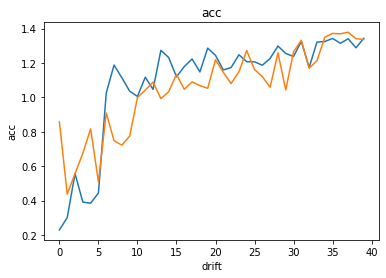

In [56]:
import matplotlib as plot
diff = list()
plt.plot(np.arange(40), np.array(addi['l2_dist']))
plt.plot(np.arange(40), np.array(addi['l2_dist_small']))
plt.title("acc")
plt.ylabel("acc")
plt.xlabel("drift")
plt.show()

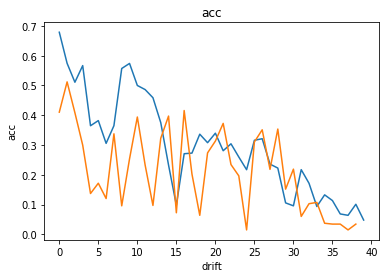

In [208]:
import matplotlib as plot
diff = list()
plt.plot(np.arange(40), np.array(addi['l2_dist']))
plt.plot(np.arange(40), np.array(addi['l2_dist_small']))
plt.title("acc")
plt.ylabel("acc")
plt.xlabel("drift")
plt.show()

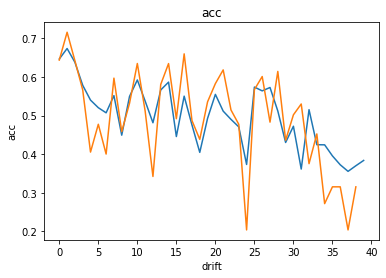

In [226]:
import matplotlib as plot
diff = list()
plt.plot(np.arange(40), np.array(addi['l2_dist']))
plt.plot(np.arange(40), np.array(addi['l2_dist_small']))
plt.title("acc")
plt.ylabel("acc")
plt.xlabel("drift")
plt.show()

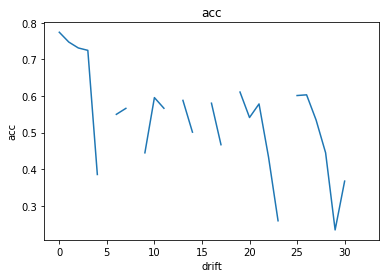

In [227]:
import matplotlib as plot
diff = list()
# plt.plot(np.arange(40), np.array(addi['l2_dist']))
# plt.plot(np.arange(40), np.array(addi['l2_dist_small']))
plt.plot(np.arange(40), np.array(addi['l2_dist_very_small']))
plt.title("acc")
plt.ylabel("acc")
plt.xlabel("drift")
plt.show()

In [223]:
addi['l2_dist_very_small']

[0.774512089804372,
 0.7476688302917727,
 0.7315288734704042,
 0.725,
 0.3854968163563197,
 nan,
 0.55,
 0.5663548219609025,
 nan,
 0.444792000470497,
 0.5957693690501276,
 0.5665899936744794,
 nan,
 0.5881703515355937,
 0.5013012557971387,
 nan,
 0.5804697207068757,
 0.4669698602928606,
 nan,
 0.6109486643625118,
 0.5413548219609023,
 0.5784699263338492,
 0.4328864100952949,
 0.2589397205857211,
 nan,
 0.6014364721865337,
 0.6033646356613631,
 0.5344662709754296,
 0.444792000470497,
 0.23393972058572116,
 0.3673497269112418,
 nan,
 0.44196986029286056,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

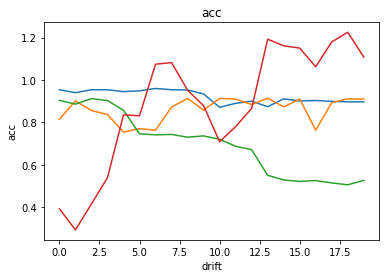

In [53]:
import matplotlib as plot
diff = list()
plt.plot(np.arange(20), np.array(res['model_aggr']['test_0to4']['acc']))
plt.plot(np.arange(20), np.array(res['model_0to4']['test_0to4']['acc']))
plt.plot(np.arange(20), np.array(res['model_5to9']['test_0to4']['acc']))
plt.plot(np.arange(20), np.array(addi['l2_dist']))
plt.title("acc")
plt.ylabel("acc")
plt.xlabel("drift")
plt.show()

In [56]:
res['req_rounds']

[1, 1, 2, 1, 1, 1, 1, 2, 2, 3, 4, 6, 4, 4, 5, 5, 6, 8, 6, 6]

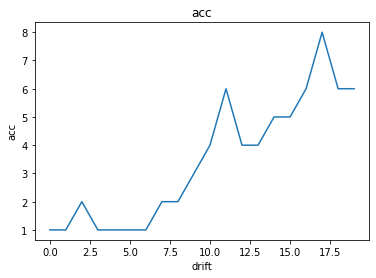

In [57]:
import matplotlib as plot
diff = list()
plt.plot(np.arange(20), np.array(res['req_rounds']))
plt.title("acc")
plt.ylabel("acc")
plt.xlabel("drift")
plt.show()

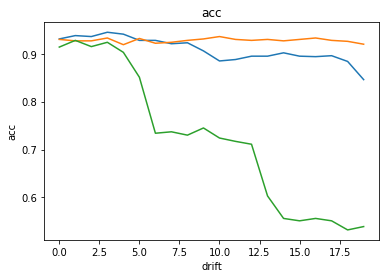

In [45]:
import matplotlib as plot
diff = list()
plt.plot(np.arange(20), np.array(res['model_aggr']['test_0to4']['acc']))
plt.plot(np.arange(20), np.array(res['model_0to4']['test_0to4']['acc']))
plt.plot(np.arange(20), np.array(res['model_5to9']['test_0to4']['acc']))
plt.title("acc")
plt.ylabel("acc")
plt.xlabel("drift")
plt.show()

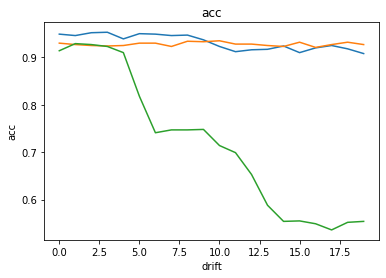

In [53]:
import matplotlib as plot
diff = list()
plt.plot(np.arange(20), np.array(mult_res['model_aggr']['test_0to4']['acc']))
plt.plot(np.arange(20), np.array(mult_res['model_0to4']['test_0to4']['acc']))
plt.plot(np.arange(20), np.array(mult_res['model_5to9']['test_0to4']['acc']))
plt.title("acc")
plt.ylabel("acc")
plt.xlabel("drift")
plt.show()

In [39]:
def two_models_federated_learning(model, epochs, rounds, x_train, y_train, x_test, y_test, size):
    # result dict
    num_total_classes = 10 # todo np.unique(y_train)
    
    res = {}
    res['model_aggr'] = {}
    res['model_0to4'] = {}
    res['model_5to9'] = {}
    res['model_aggr']['test_all'] = {}
    res['model_aggr']['test_0to4'] = {}
    res['model_aggr']['test_5to9'] = {}
    
    res['model_0to4'] = copy.deepcopy(res['model_aggr'])
    res['model_5to9'] = copy.deepcopy(res['model_aggr'])
    
    # initialize models
    model1 = keras.models.clone_model(model)
    model2 = keras.models.clone_model(model)
    model1.set_weights(model.get_weights())
    model2.set_weights(model.get_weights())
    compile_model(model1)
    compile_model(model2)
    
    # get training dataset
    x1, y1 = utils.filter_data_by_labels(x_train, y_train, np.arange(5), size, 0, 123)
    x2, y2 = utils.filter_data_by_labels(x_train, y_train, np.arange(5)+5, size, 0, 1234)
    
    y1 = keras.utils.to_categorical(y1, num_total_classes)
    y2 = keras.utils.to_categorical(y2, num_total_classes)
    
    # get test dataset
    y_test_one_hot = keras.utils.to_categorical(y_test, num_total_classes)
    tx1, ty1 = utils.filter_data_by_labels(x_test, y_test, np.arange(5), 1000)
    tx2, ty2 = utils.filter_data_by_labels(x_test, y_test, np.arange(5)+5, 1000)
    ty1 = keras.utils.to_categorical(ty1, num_total_classes)
    ty2 = keras.utils.to_categorical(ty2, num_total_classes)
    
    for r in range(rounds):
        # fit
        fit_model_with_datasets(model1, epochs, x1, y1)
        fit_model_with_datasets(model2, epochs, x2, y2)
        
        #aggregate
        weights = [model1.get_weights(), model2.get_weights()]
        agg_weights = list()
        theta = 0.5
        for weights_list_tuple in zip(*weights):
            agg_weights.append(np.array([np.average(np.array(w), axis=0, weights=[1. - theta, theta]) for w in zip(*weights_list_tuple)]))
        aggr_model = keras.models.clone_model(model1)
        aggr_model.set_weights(agg_weights)
        compile_model(aggr_model)
        
        #test
        add_hist_to_dict(res['model_0to4']['test_all'],
                         model1.evaluate(x=x_test, y=y_test_one_hot, verbose=0))
        add_hist_to_dict(res['model_0to4']['test_0to4'],
                         model1.evaluate(x=tx1, y=ty1, verbose=0))
        add_hist_to_dict(res['model_0to4']['test_5to9'],
                         model1.evaluate(x=tx2, y=ty2, verbose=0))
        
        add_hist_to_dict(res['model_5to9']['test_all'],
                         model2.evaluate(x=x_test, y=y_test_one_hot, verbose=0))
        add_hist_to_dict(res['model_5to9']['test_0to4'],
                         model2.evaluate(x=tx1, y=ty1, verbose=0))
        add_hist_to_dict(res['model_5to9']['test_5to9'],
                         model2.evaluate(x=tx2, y=ty2, verbose=0))
        
        add_hist_to_dict(res['model_aggr']['test_all'],
                         aggr_model.evaluate(x=x_test, y=y_test_one_hot, verbose=0))
        add_hist_to_dict(res['model_aggr']['test_0to4'],
                         aggr_model.evaluate(x=tx1, y=ty1, verbose=0))
        add_hist_to_dict(res['model_aggr']['test_5to9'],
                         aggr_model.evaluate(x=tx2, y=ty2, verbose=0))
        
        # update parameters
        model1.set_weights(agg_weights)
        model2.set_weights(agg_weights)
        
    return res

In [46]:
ROUNDS = 30

In [47]:
two_fl_res = two_models_federated_learning(init_model, 5, ROUNDS, x_train, y_train, x_test, y_test_orig, 600)

Training date and time : 
2020-09-10 10:20:48
Train on 600 samples
Epoch 1/5
600/600 [==============================] - 0s 202us/sample - loss: 0.0902 - acc: 0.1100
Epoch 2/5
600/600 [==============================] - 0s 41us/sample - loss: 0.0885 - acc: 0.2000
Epoch 3/5
600/600 [==============================] - 0s 40us/sample - loss: 0.0867 - acc: 0.3000
Epoch 4/5
600/600 [==============================] - 0s 40us/sample - loss: 0.0848 - acc: 0.3917
Epoch 5/5
600/600 [==============================] - 0s 43us/sample - loss: 0.0828 - acc: 0.4383
Training date and time : 
2020-09-10 10:20:49
Train on 600 samples
Epoch 1/5
600/600 [==============================] - 0s 175us/sample - loss: 0.0883 - acc: 0.1567
Epoch 2/5
600/600 [==============================] - 0s 40us/sample - loss: 0.0869 - acc: 0.2450
Epoch 3/5
600/600 [==============================] - 0s 36us/sample - loss: 0.0855 - acc: 0.3033
Epoch 4/5
600/600 [==============================] - 0s 36us/sample - loss: 0.0841 - acc

600/600 [==============================] - 0s 41us/sample - loss: 0.0317 - acc: 0.9117
Training date and time : 
2020-09-10 10:21:09
Train on 600 samples
Epoch 1/5
600/600 [==============================] - 0s 35us/sample - loss: 0.0631 - acc: 0.6350
Epoch 2/5
600/600 [==============================] - 0s 36us/sample - loss: 0.0555 - acc: 0.6700
Epoch 3/5
600/600 [==============================] - 0s 35us/sample - loss: 0.0513 - acc: 0.7167
Epoch 4/5
600/600 [==============================] - 0s 36us/sample - loss: 0.0481 - acc: 0.7417
Epoch 5/5
600/600 [==============================] - 0s 36us/sample - loss: 0.0453 - acc: 0.7900
Training date and time : 
2020-09-10 10:21:11
Train on 600 samples
Epoch 1/5
600/600 [==============================] - 0s 42us/sample - loss: 0.0449 - acc: 0.8800
Epoch 2/5
600/600 [==============================] - 0s 45us/sample - loss: 0.0364 - acc: 0.9017
Epoch 3/5
600/600 [==============================] - 0s 45us/sample - loss: 0.0318 - acc: 0.9117
Epo

600/600 [==============================] - 0s 43us/sample - loss: 0.0102 - acc: 0.9517
Epoch 4/5
600/600 [==============================] - 0s 51us/sample - loss: 0.0097 - acc: 0.9517
Epoch 5/5
600/600 [==============================] - 0s 47us/sample - loss: 0.0093 - acc: 0.9533
Training date and time : 
2020-09-10 10:21:54
Train on 600 samples
Epoch 1/5
600/600 [==============================] - 0s 45us/sample - loss: 0.0214 - acc: 0.9100
Epoch 2/5
600/600 [==============================] - 0s 41us/sample - loss: 0.0168 - acc: 0.9250
Epoch 3/5
600/600 [==============================] - 0s 43us/sample - loss: 0.0157 - acc: 0.9333
Epoch 4/5
600/600 [==============================] - 0s 43us/sample - loss: 0.0151 - acc: 0.9317
Epoch 5/5
600/600 [==============================] - 0s 43us/sample - loss: 0.0145 - acc: 0.9350
Training date and time : 
2020-09-10 10:21:58
Train on 600 samples
Epoch 1/5
600/600 [==============================] - 0s 42us/sample - loss: 0.0151 - acc: 0.9333
Epo

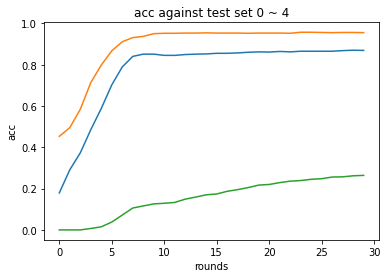

In [48]:
import matplotlib as plot
diff = list()
plt.plot(np.arange(ROUNDS), np.array(two_fl_res['model_aggr']['test_0to4']['acc']))
plt.plot(np.arange(ROUNDS), np.array(two_fl_res['model_0to4']['test_0to4']['acc']))
plt.plot(np.arange(ROUNDS), np.array(two_fl_res['model_5to9']['test_0to4']['acc']))
plt.title("acc against test set 0 ~ 4")
plt.ylabel("acc")
plt.xlabel("rounds")
plt.show()

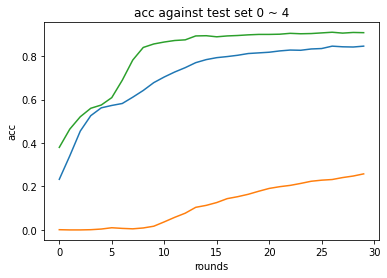

In [49]:
import matplotlib as plot
diff = list()
plt.plot(np.arange(ROUNDS), np.array(two_fl_res['model_aggr']['test_5to9']['acc']))
plt.plot(np.arange(ROUNDS), np.array(two_fl_res['model_0to4']['test_5to9']['acc']))
plt.plot(np.arange(ROUNDS), np.array(two_fl_res['model_5to9']['test_5to9']['acc']))
plt.title("acc against test set 0 ~ 4")
plt.ylabel("acc")
plt.xlabel("rounds")
plt.show()